In [1]:
!pip install transformers bitsandbytes datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 75.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing i

In [2]:
from datasets import load_dataset 

train_df = load_dataset("arampacha/rsicd", split="train")
val_df = load_dataset("arampacha/rsicd", split="valid")
test_df = load_dataset("arampacha/rsicd", split="test")

dataset_infos.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/419M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/55.1M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/51.6M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8734 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1093 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1094 [00:00<?, ? examples/s]

In [3]:
# Retaining only the first caption for fine-tuning

# train_df = train_df.map(lambda example: {"captions": example["captions"][0]})
# val_df = val_df.map(lambda example: {"captions": example["captions"][0]})
# test_df = test_df.map(lambda example: {"captions": example["captions"][0]})

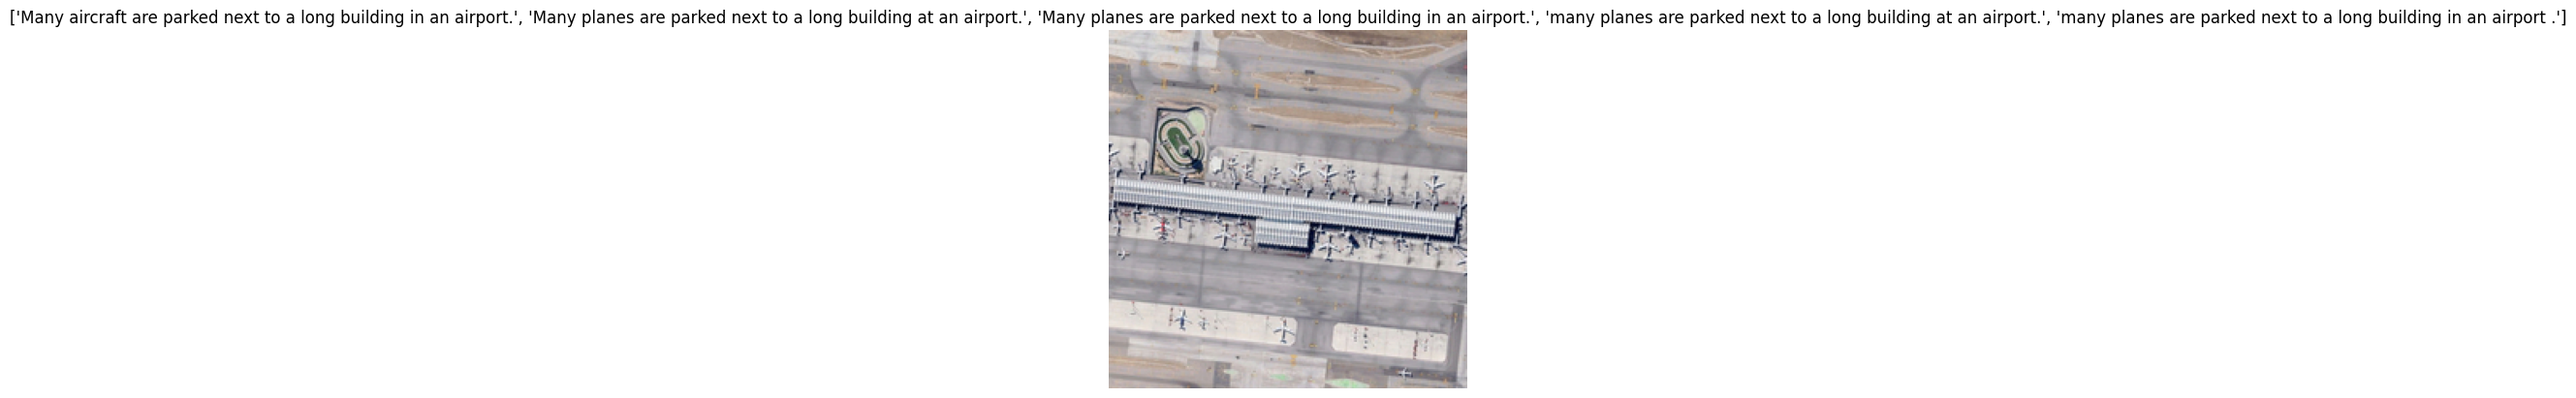

In [4]:
import matplotlib.pyplot as plt

def show_caption_and_img(dataset, ind):
    plt.axis('off')
    plt.imshow(dataset[ind]["image"])
    plt.title(dataset[ind]["captions"])

show_caption_and_img(train_df, 0)
# show_caption_and_img(val_df, 0)
# show_caption_and_img(test_df, 10)

In [5]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["captions"] = item["captions"]
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "captions":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["captions"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


In [6]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto")

2025-05-21 07:00:47.953760: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747810848.157891      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747810848.216500      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/127k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.
Expanding inputs for image tokens in BLIP-2 should be done in processing. Please follow instruction here (https://gist.github.com/zucchini-nlp/e9f20b054fa322f84ac9311d9ab67042) to update your BLIP-2 model. Using processors without these attributes in the config is deprecated and will throw an error in v4.50.
Both `max_new_tokens` (=50) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Generated Caption: an aerial view of a beach with people and umbrellas
Reference Captions: ['There are many people who play both in the sea and on the beach.', 'there are many people playing both in the sea and on the beach .', 'people swim inthe jade green sea and take a sunbath on the beach .', 'lots of people are sitting on the curved edge of the beach .', 'many people are in a yellow beach near a green ocean .']


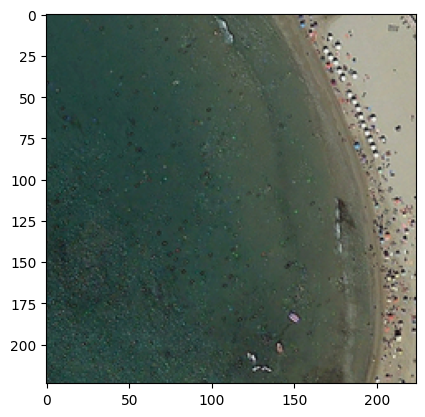

In [7]:
def generate_caption(index, test_df, model, processor, num_beams=5, max_new_tokens=50, length_penalty=0):
    import torch
    model.eval()
    device = next(model.parameters()).device

    example = test_df[index]
    image = example["image"]
    plt.imshow(image)
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        generated_ids = model.generate(
            pixel_values=inputs["pixel_values"],
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            # length_penalty=length_penalty,
            # early_stopping=True
        )
    
    caption = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return caption.strip()

idx = 102  # Index of the image in test_df
caption = generate_caption(idx, test_df, model, processor)
print(f"Generated Caption: {caption}")
print(f"Reference Captions: {test_df[idx]['captions']}")

In [8]:
pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 16.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from pycocoevalcap.eval import COCOEvalCap
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

In [10]:
# Prepare the dataloader
test_dataset = ImageCaptioningDataset(test_df, processor)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [11]:
len(test_loader)

137

In [12]:
references = []
predictions = []

for example in test_df:
    refs = [cap.lower().strip() for cap in example["captions"]]  # list of 5 refs per image
    # Generate caption
    inputs = processor(images=example["image"], return_tensors="pt").to(model.device)
    generated_ids = model.generate(
    pixel_values=inputs["pixel_values"],
    max_new_tokens=50,
    num_beams=5,            # beam search width
    early_stopping=True
)

    pred_caption = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0].lower().strip()
    
    references.append(refs)
    predictions.append(pred_caption)

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.
Both `max_new_tokens` (=50) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/acceler

In [13]:
# import matplotlib.pyplot as plt

# for i in range(5):
#     image = test_df[i]['image']
#     plt.imshow(image)
#     plt.axis('off')
#     plt.title("Predicted: " + predictions[i], fontsize=10)
#     plt.show()

#     print("Reference Captions:")
#     for ref in references[i]:
#         print(f" - {ref}")

In [14]:
from pycocoevalcap.bleu.bleu import Bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

refs_dict = {str(i): refs for i, refs in enumerate(references)}       # refs is list of captions
preds_dict = {str(i): [pred] for i, pred in enumerate(predictions)}   # pred wrapped in a list

bleu_scorer = Bleu()
meteor_scorer = Meteor()
rouge_scorer = Rouge()
cider_scorer = Cider()

bleu_score, _ = bleu_scorer.compute_score(refs_dict, preds_dict)
meteor_score, _ = meteor_scorer.compute_score(refs_dict, preds_dict)
rouge_score, _ = rouge_scorer.compute_score(refs_dict, preds_dict)
cider_score, _ = cider_scorer.compute_score(refs_dict, preds_dict)

print("BLEU-1 to BLEU-4:", bleu_score)
print("METEOR:", meteor_score)
print("ROUGE:", rouge_score)
print("CIDEr:", cider_score)


{'testlen': 10020, 'reflen': 10942, 'guess': [10020, 8927, 7834, 6741], 'correct': [3984, 836, 165, 44]}
ratio: 0.9157375251324332
BLEU-1 to BLEU-4: [0.3626515859351193, 0.17600059996133186, 0.08411153307227534, 0.043384364689906786]
METEOR: 0.10560858048357648
ROUGE: 0.2259267079011192
CIDEr: 0.15191817384306547


In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Trainable parameters: {num_params:,}")

Trainable parameters: 3,744,679,936


In [16]:
from torch.profiler import profile, record_function, ProfilerActivity

sample = test_df[0]
inputs = processor(images=sample["image"], return_tensors="pt").to(model.device)
# Optional warm-up
for _ in range(2):
    _ = model.generate(pixel_values=inputs["pixel_values"], max_new_tokens=20)

# Profile
with profile(
    activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    with_stack=True,
    record_shapes=True,
    profile_memory=True,
    with_flops=True
) as prof:
    with torch.no_grad():
        with record_function("blip2_caption_generation"):
            _ = model.generate(pixel_values=inputs["pixel_values"], max_new_tokens=20)

# Print total FLOPs
flops = prof.key_averages().total_average().flops
print(f"Total GFLOPs (image to caption): {flops / 1e9:.2f}")

The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.
Both `max_new_tokens` (=20) and `max_length`(=51) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/acceler

Total GFLOPs (image to caption): 761.17


In [17]:
import time

# Warm-up
for _ in range(3):
    _ = model.generate(pixel_values=inputs["pixel_values"])

# Time single forward pass
n_runs = 10
total_time = 0

for _ in range(n_runs):
    start = time.time()
    _ = model.generate(pixel_values=inputs["pixel_values"], max_new_tokens=50)
    torch.cuda.synchronize()  # Wait for GPU to finish
    total_time += (time.time() - start)

avg_time = total_time / n_runs
print(f"Average inference time per image: {avg_time:.3f} seconds")


The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.
The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when using `accelerate`. Please pass a `device_map` that contains `language_model` to remove this warning. Please refer to https://github.com/huggingface/blog/blob/main/accelerate-large-models.md for more details on creating a `device_map` for large models.
The `language_model` is not in the `hf_device_map` dictionary and you are running your script in a multi-GPU environment. this may lead to unexpected behavior when us

Average inference time per image: 0.844 seconds
